In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import scipy, implicit
print("SciPy:", scipy.__version__)
print("implicit:", implicit.__version__)

/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SciPy: 1.11.3
implicit: 0.7.2


In [2]:
usr = pd.read_csv('data/user_ratings.csv')
usr.head()

,BGGId,Rating,Username
0,213788,8.0,Tonydorrf
1,213788,8.0,tachyon14k
2,213788,8.0,Ungotter
3,213788,8.0,brainlocki3
4,213788,8.0,PPMP


In [3]:
ratings_per_users = usr.groupby('Username').size()
ratings_per_movies = usr.groupby('BGGId').size()

In [5]:
usr['MappedRating'] = np.where(usr['Rating'] <= 4, -1,
                       np.where(usr['Rating'] <= 7, 0, 1))

In [9]:
keep = ratings_per_users[ratings_per_users >= 5].index
usr = usr[usr['Username'].isin(keep)]

<Axes: >

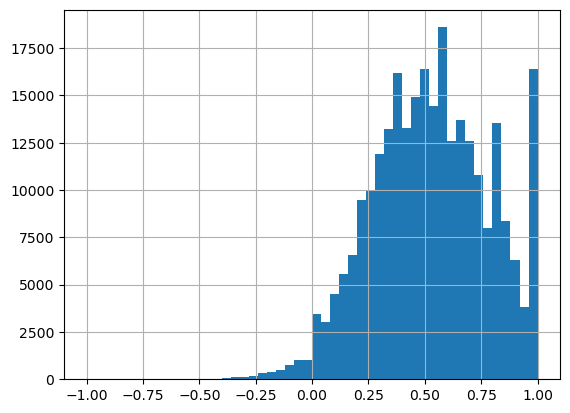

In [10]:
usr.groupby('Username')['MappedRating'].mean().hist(bins=50)


In [11]:
user_map = {u: i for i, u in enumerate(usr['Username'].unique())}
game_map = {g: j for j, g in enumerate(usr['BGGId'].unique())}

rows = usr['Username'].map(user_map)
cols = usr['BGGId'].map(game_map)

rows.shape

(18696365,)

In [96]:
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from implicit.als import AlternatingLeastSquares

def create_A_matrix(users, items, ratings):

    unique_users = np.sort(users.unique())
    unique_items = np.sort(items.unique())
    user_map = {user: i for i, user in enumerate(unique_users)}
    item_map = {item: i for i, item in enumerate(unique_items)}
    rows = users.map(user_map)
    cols = items.map(item_map)

    #mask = ratings.notna()
    A = coo_matrix((ratings, (rows,cols)), shape=(len(user_map), len(item_map)))

    return A, user_map, item_map


A, user_map, item_map = create_A_matrix(usr['Username'], usr['BGGId'], usr['Rating'])
rows, cols, data = A.row, A.col, A.data
indices = np.arange(len(data))
train, test = train_test_split(indices, test_size=0.05, random_state=42)

train_rows, train_cols, train_data = rows[train], cols[train], data[train]
#val_rows, val_cols, val_data = rows[test_index], cols[test_index], data[test_index]

A_train = coo_matrix((train_data, (train_rows, train_cols)), shape=A.shape)


In [14]:
def als(R, k=2, W= None, lambda_=0.1, n_iters=10 ):
    m, n = R.shape

    #Global mean
    mu = R.data.mean()
    
    # Initialize parameters
    U = np.random.normal(scale=1./k, size=(m, k))
    V = np.random.normal(scale=1./k, size=(n, k))
    b_user = np.zeros(m)
    b_item = np.zeros(n)

    #create two versions for row and column operations
    R_csr = R.tocsr()
    R_csc = R.tocsc()


    if W is None:
        W = csr_matrix(R_csr.copy())
        W.data[:] = 1.0
    W_csr = W.tocsr()
    W_csc = W.tocsc()

    nonzero_users = np.unique(R_csr.nonzero()[0])
    nonzero_items = np.unique(R_csc.nonzero()[1])
    for _ in range(n_iters):
        #print(f'Iteration {_+1}/{n_iters}')
        # Update user features
        for i in nonzero_users:
            start, end = R_csr.indptr[i], R_csr.indptr[i+1]
            idx  = R_csr.indices[start:end]
            r_i = R_csr.data[start:end] 
            w_i = W_csr.data[start:end]
            if len(idx) > 0:
                V_i = V[idx, :]
                W_i = np.diag(w_i)
                r_i_centered = r_i - mu - b_user[i] - b_item[idx]
                A = V_i.T @ W_i @ V_i + lambda_ * np.eye(k)
                b = V_i.T @ (W_i @ r_i_centered)
                U[i] = np.linalg.solve(A,b)

                #update user bias
                pred = V_i @ U[i]
                b_user[i] = np.average(r_i - pred - mu - b_item[idx], weights = w_i)

        # Update item features
        for j in nonzero_items:
            start, end = R_csc.indptr[j], R_csc.indptr[j+1]
            idx  = R_csc.indices[start:end]            
            r_j = R_csc.data[start:end]
            w_j = W_csc.data[start:end]
            if len(idx) > 0:
                U_j = U[idx,:]
                W_j = np.diag(w_j)
                r_j_centered = r_j - mu - b_user[idx] - b_item[j]
                A = U_j.T @  W_j @ U_j + lambda_ * np.eye(k)
                b = U_j.T @ (W_j @ r_j_centered)
                V[j] = np.linalg.solve(A,b)

                #udate item bias    
                pred = U_j @ V[j]
                b_item[j] = np.average(r_j - pred - mu - b_user[idx], weights = w_j)
    return U, V, b_user, b_item, mu

In [15]:

from sklearn.model_selection import KFold
from implicit.als import AlternatingLeastSquares 

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


import numpy as np

def recall_at_k(U, V, A_train, A_val, k=10, batch_size=512, verbose=False):
    """
    Compute Recall@K for validation set A_val given factor matrices U, V,
    and training matrix A_train (for masking), using batched scoring.
    """
    A_train_csr = A_train.tocsr()
    A_val_csr = A_val.tocsr()
    n_users = A_val.shape[0]
    recalls = []

    for start in range(0, n_users, batch_size):
        end = min(start + batch_size, n_users)
        if verbose and start % (batch_size * 10) == 0:
            print(f"Processing users {start}-{end} / {n_users}")

        # batch of users
        U_batch = U[start:end]                      # (batch_size, k)
        scores_batch = U_batch @ V.T                # (batch_size, n_items)

        # mask training items for each user
        for i, u in enumerate(range(start, end)):
            train_items = A_train_csr[u].indices
            if len(train_items) > 0:
                scores_batch[i, train_items] = -np.inf

        # compute recall for each user in the batch
        for i, u in enumerate(range(start, end)):
            val_items = A_val_csr[u].indices
            if len(val_items) == 0:
                continue
            topk = np.argpartition(scores_batch[i], -k)[-k:]
            recall = len(np.intersect1d(val_items, topk)) / len(val_items)
            recalls.append(recall)

    return np.mean(recalls) if recalls else np.nan


def recall_at_k_implicit(U, V, P_train, P_val, k=10, batch_size=512, verbose=False):
    """
    Compute Recall@K for implicit ALS factors, using batched scoring.
    """
    csr_train, csr_val = P_train.tocsr(), P_val.tocsr()
    n_users = U.shape[0]
    recalls = []

    for start in range(0, n_users, batch_size):
        end = min(start + batch_size, n_users)
        if verbose and start % (batch_size * 10) == 0:
            print(f"Processing users {start}-{end} / {n_users}")

        # batch scoring
        U_batch = U[start:end]
        scores_batch = U_batch @ V.T

        # mask known positives
        for i, u in enumerate(range(start, end)):
            train_items = csr_train[u].indices
            if len(train_items) > 0:
                scores_batch[i, train_items] = -np.inf

        # compute per-user recall
        for i, u in enumerate(range(start, end)):
            val_items = csr_val[u].indices
            if len(val_items) == 0:
                continue
            topk = np.argpartition(scores_batch[i], -k)[-k:]
            recall = len(np.intersect1d(val_items, topk)) / len(val_items)
            recalls.append(recall)

    return np.mean(recalls) if recalls else np.nan

def precision_at_k(U, V,A_val, k=10, verbose=False):
    precisions = []

    VT = V.T
    val_items = np.unique(A_val.col)

    for u in range(U.shape[0]):
        if u % 1000 == 0 and verbose:
            print(f'Processing user {u}/{U.shape[0]}')
        row = A_val.getrow(u).tocoo()
        if row.nnz < 2: # skip users with less than 2 ratings, 1 rating is useless for precision
            continue
        y_true = row.col[row.data > 0] # liked items
        if len(y_true) == 0:
            continue
        y_scores = U[u, :] @ VT[:,val_items]
        topkidx = np.argpartition(-y_scores, k)[:k] #efficient lookup of top k indices
        y_pred = val_items[topkidx[np.argsort(-y_scores[topkidx])]]  # top-k items

        hits = np.intersect1d(y_true, y_pred) # how many of the true liked items are in the top-k predictions
        precision = len(hits) / k # fraction of hits that were in the top 10 predictions
        precisions.append(precision)
        
    return -np.mean(precisions) if precisions else np.nan
    

def cv_als(A, k=5,W=None, als_params = {'k':20, 'lambda':0.1, 'n_iters':10, 'alpha':15} ):

    rmses = []
    recalls = []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    rows, cols, data = A.row, A.col, A.data
    #indices = np.arange(len(data))
    indices = np.arange(len(data))

    for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
        #print("TRAIN:", train_index, "TEST:", test_index)

        train_rows, train_cols, train_data = rows[train_idx], cols[train_idx], data[train_idx]
        val_rows, val_cols, val_data = rows[val_idx], cols[val_idx], data[val_idx]

        A_fold_train = coo_matrix((train_data, (train_rows, train_cols)), shape=A.shape)
        A_fold_val = coo_matrix((val_data, (val_rows, val_cols)), shape=A.shape)
        
        # Train your model on A_train here
         # train implicit ALS
        model = AlternatingLeastSquares(
            factors=als_params['k'],
            regularization=als_params['lambda'],
            iterations=als_params['n_iters'],
            num_threads=8
        )
        model.fit(A_fold_train)

        U, V = model.user_factors, model.item_factors



        # Evaluate your model on A_test here
        #A_pred = U @ V.T
        # Compute RMSE on the test set
        #print(f"Fold {fold+1}")
        #print(U.shape, V.shape)
        #test values
        y_test = A_fold_val.data

        #get predictions from the predicted matrix
        latent_pred = np.einsum('ij,ij->i', U[A_fold_val.row], V[A_fold_val.col])

        b_user = np.zeros(A.shape[0])
        b_item = np.zeros(A.shape[1])
        mu = A_fold_train.data.mean()
        

        #add biases and global mean
        y_pred = mu + b_user[A_fold_val.row] + b_item[A_fold_val.col] + latent_pred
        r_at_k = recall_at_k(U, V,A_fold_train, A_fold_val, k=10)
        rmse_ = rmse(y_test, y_pred)
        rmses.append(rmse_)
        recalls.append(r_at_k)

    return np.mean(rmses), np.mean(recalls)


def cv_als_implicit(A, n_splits=5, als_params={'k':20, 'lambda':0.1, 'n_iters':10, 'alpha':15}):
    """
    Cross-validation for implicit ALS using user-level splits.
    Returns mean Recall@10 across folds.
    """
    recalls = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    rows, cols, data = A.row, A.col, A.data
    users = np.arange(A.shape[0])

    for fold, (train_users, val_users) in enumerate(kf.split(users)):
        print(f"Fold {fold+1}/{n_splits}")

        # mask by users
        train_mask = np.isin(rows, train_users)
        val_mask   = np.isin(rows, val_users)

        train_rows, train_cols, train_data = rows[train_mask], cols[train_mask], data[train_mask]
        val_rows, val_cols, val_data       = rows[val_mask],   cols[val_mask],   data[val_mask]

        A_train = coo_matrix((train_data, (train_rows, train_cols)), shape=A.shape)
        A_val   = coo_matrix((val_data,   (val_rows,   val_cols)),   shape=A.shape)

        # confidence matrix: C = 1 + alpha * R
        C = (A_train * als_params['alpha']).astype(np.float32).tocsr()
        C.data = 1 + C.data

        # train implicit ALS
        model = AlternatingLeastSquares(
            factors=als_params['k'],
            regularization=als_params['lambda'],
            iterations=als_params['n_iters'],
            num_threads=8
        )
        model.fit(C)

        # evaluate Recall@10
        U, V = model.user_factors, model.item_factors
        r_at_k = recall_at_k_implicit(U, V, A_train, A_val, k=10, batch_size=1024)
        print(f"Recall@10 = {r_at_k:.4f}")
        recalls.append(r_at_k)

    return np.nanmean(recalls)


def make_holdout_split(P, val_franction = 0.2, seed=42):
    np.random.seed(seed)

    csr = P.tocsr()
    rows_t, cols_t, data_t = [], [], []
    rows_v, cols_v, data_v = [], [], []

    for u in range(P.shape[0]):
        items = csr[u].indices
        n_items = len(items)
        if n_items == 0:
            continue    

        n_val = max(1, int(n_items * val_franction))
        val_indices = np.random.choice(items, size=n_val, replace=False)
        train_indices = np.setdiff1d(items, val_indices)

        vals = csr[u].data
        train_mask = np.isin(items, train_indices)
        val_mask = np.isin(items, val_indices)

        rows_t += [u] * np.sum(train_mask)
        cols_t += items[train_mask].tolist()
        data_t += vals[train_mask].tolist()
        rows_v += [u] * np.sum(val_mask)
        cols_v += items[val_mask].tolist()
        data_v += vals[val_mask].tolist()

    P_train = coo_matrix((data_t, (rows_t, cols_t)), shape=P.shape).tocsr()
    P_val = coo_matrix((data_v, (rows_v, cols_v)), shape=P.shape).tocsr()
    return P_train, P_val



In [16]:
def weight_matrix(weight_dict, A):
    W = csr_matrix(A.copy())
    W.data = np.array([weight_dict.get(rating, 1.0) for rating in A.data])
    return W

In [ ]:
# grid search for hyperparameter tuning
import random 
np.random.seed(42)
import itertools
import time 

k_values = [16,24,32,48]
lambda_values = [0.001, 0.01, 0.1, 1.0]
n_iters_values = [10,20]
best_score = -np.inf
weights_dicts = [{-1: 1.0, 0: 0.5, 1: 2.0}, 
                 {-1: 1.0, 0: 1.0, 1: 1.0}, {-1: 1.5, 0: 0.5, 1:1.5} ,
                 {-1: 2.0, 0: 0.5, 1: 1.0}]
alphas = [1,10,20]
best_params = None
results = []
keep = ratings_per_users[ratings_per_users >= 50].index

sample_user_indices = [user_map[u] for u in keep.unique()]

# For faster computation during hyperparameter tuning, we can sample a subset of users
A_small = A_train.tocsr()[sample_user_indices, :].tocoo()

R = A_small.copy()
R.data = np.where(R.data > 0, 1.0, 0.0)  # implicit feedback: liked or not
grid = random.sample(list(itertools.product(k_values, lambda_values, n_iters_values, alphas)) , 20)

# Grid search loop
for k, lambda_, n_iters, alpha in grid:
    print(f"\nEvaluating for k={k}, lambda={lambda_}, n_iters={n_iters}, alpha={alpha}")
    t0 = time.time()

    recall = cv_als_implicit(
        R,
        n_splits=3,
        als_params={'k': k, 'lambda': lambda_, 'n_iters': n_iters, 'alpha': alpha}
    )

    runtime_min = (time.time() - t0) / 60
    print(f"Average Recall@10: {recall:.4f} (took {runtime_min:.2f} min)")

    results.append({'k': k, 'lambda': lambda_, 'n_iters': n_iters, 'alpha': alpha,
                    'recall': recall, 'runtime_min': runtime_min})

    if recall > best_score:
        best_score = recall
        best_params = (k, lambda_, n_iters, alpha)

print(f"\nBest params: k={best_params[0]}, lambda={best_params[1]}, n_iters={best_params[2]}, "
      f"alpha={best_params[3]} with Recall@10={best_score:.4f}")

results_df = pd.DataFrame(results).sort_values('recall', ascending=False)

In [61]:
def build_confidence_matrix(R, alpha = 20, r_min = 1, r_max = 10, gamma = 1.0):
    R_scaled = R.copy().astype(np.float32)
    R_scaled.data = np.clip((R_scaled.data - r_min) / (r_max - r_min), 0, 1)
    if gamma != 1.0:
        R_scaled.data = R_scaled.data ** gamma

    C = R_scaled.tocsr()
    C.data = 1 + alpha * C.data
    return C 

In [ ]:
# grid search for hyperparameter tuning
from implicit.evaluation import mean_average_precision_at_k, ndcg_at_k , precision_at_k, ranking_metrics_at_k, leave_k_out_split
import random 
np.random.seed(42)
import itertools
import time 

k_values = [32,64, 128]
lambda_values = [0.0001, 0.01, 1.0]
n_iters_values = [20]
best_score = -np.inf
alphas = [50, 100]
gammas = [1.0,2.0]
best_params = None
results = []
keep = ratings_per_users[ratings_per_users >= 10].index

sample_user_indices = [user_map[u] for u in keep.unique()]

# For faster computation during hyperparameter tuning, we can sample a subset of users
R = A_train.tocsr()[sample_user_indices, :].tocoo()

#R.data = np.where(R.data > 0, 1.0, 0.0)  # implicit feedback: liked or not
grid = random.sample(list(itertools.product(k_values, lambda_values, n_iters_values, alphas)) , 20)

results = []
# Grid search loop
for k, lambda_, n_iters, alpha in grid:
    print(f"\nEvaluating for k={k}, lambda={lambda_}, n_iters={n_iters}, alpha={alpha}")
    t0 = time.time()
    map_at_ks = []
    ndcg_ks = []
    precision_ks = []
    ranking_ks = []
    for seed in range(3):
        train, val = leave_k_out_split(R, K=1, random_state=42+seed)
        model = AlternatingLeastSquares(factors = k,
                                        regularization=lambda_,
                                        iterations=n_iters)
        C = build_confidence_matrix(train, alpha=alpha)
        model.fit(C.T)
        ranking_k = ranking_metrics_at_k(model, train.T, val.T, K=10)
        map_at_ks.append(ranking_k['map'])
        ndcg_ks.append(ranking_k['ndcg'])
        precision_ks.append(ranking_k['precision'])
    
    results.append({'k': k, 'lambda': lambda_, 'n_iters': n_iters, 'alpha': alpha, 'map_at_10': np.mean(map_at_ks),
                    'ndcg_at_10': np.mean(ndcg_ks), 'precision_at_10': np.mean(precision_ks),
                    'runtime_min': (time.time() - t0) / 60})
    print(f"Mean MAP@10: {np.mean(map_at_ks):.4f}, NDCG@10: {np.mean(ndcg_ks):.4f}, Precision@10: {np.mean(precision_ks):.4f} (took {(time.time() - t0) / 60:.2f} min)")

results_df = pd.DataFrame(results).sort_values('map_at_10', ascending=False)


        


Evaluating for k=32, lambda=0.01, n_iters=20, alpha=10


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2981069087982178 seconds
  warnings.warn(
100%|██████████| 14502/14502 [00:08<00:00, 1774.77it/s]
/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2964751720428467 seconds
  warnings.warn(
100%|██████████| 14519/14519 [00:08<00:00, 1734.28it/s]
/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.3023688793182373 seconds
  warnings.warn(
100%|██████████| 14497/14497 [00:08<00:00, 1796.69it/s]


Mean MAP@10: 0.0009, NDCG@10: 0.0020, Precision@10: 0.0034 (took 10.02 min)

Evaluating for k=32, lambda=0.001, n_iters=10, alpha=1


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.3025798797607422 seconds
  warnings.warn(
100%|██████████| 14572/14572 [00:08<00:00, 1713.04it/s]
/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.3089771270751953 seconds
  warnings.warn(
100%|██████████| 14463/14463 [00:08<00:00, 1784.07it/s]
/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.29596590995788574 seconds
  warnings.warn(
100%|██████████| 14476/14476 [00:08<00:00, 1734.74it/s]


Mean MAP@10: 0.0006, NDCG@10: 0.0015, Precision@10: 0.0027 (took 5.47 min)

Evaluating for k=24, lambda=0.001, n_iters=20, alpha=20


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2968790531158447 seconds
  warnings.warn(
100%|██████████| 14439/14439 [00:09<00:00, 1463.80it/s]
/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.30200982093811035 seconds
  warnings.warn(
100%|██████████| 14481/14481 [00:07<00:00, 1832.27it/s]
/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.3239753246307373 seconds
  warnings.warn(
 20%|██        | 4/20 [00:49<03:17, 12.37s/it]


KeyboardInterrupt: 

In [55]:
k_values = [16,32,64]
lambda_values = [0.0001, 0.01, 1.0]
n_iters_values = [20]
best_score = -np.inf
alphas = [50, 100]
gammas = [1.0,2.0]

from implicit.nearest_neighbours import bm25_weight

# Re-weight implicit feedback

train, val = leave_k_out_split(R, K=5, random_state=42+seed)

X = bm25_weight(train, K1=1.2, B=0.75)

results = []
param_grid = [
    (128, 0.01, 25, 160, 3.0),
    (128, 0.03, 25, 160, 3.0),
    (128, 0.01, 25, 200, 3.0),
    (128, 0.01, 25, 160, 4.0),
    (192, 0.01, 20, 160, 3.0),
    (192, 0.03, 20, 160, 3.0),
    (192, 0.01, 20, 200, 3.0),
    (256, 0.03, 20, 160, 3.0),
    (256, 0.03, 20, 200, 3.0),
    (128, 0.01, 20, 160, 3.0)  # cg_steps=4
]

for k, lambda_, n_iters, alpha, gamma in param_grid:
    print(f"Evaluating k={k}, λ={lambda_}, iters={n_iters}, α={alpha}, gamma={gamma}")
    C = build_confidence_matrix(X, alpha=alpha, gamma = gamma)
    model = AlternatingLeastSquares(factors=k,
                                    regularization=lambda_,
                                    iterations=n_iters,
                                    random_state=42)
    model.fit(C.T)

    # Evaluation (user×item)
    train_ui = train.T.tocsr().astype(np.float32)
    val_ui   = val.T.tocsr().astype(np.float32)
    ranking_k = ranking_metrics_at_k(model, train_ui, val_ui, K=10)
    results.append((k, lambda_, n_iters, alpha,gamma, ranking_k['precision'], ranking_k['ndcg'], ranking_k['map']))

results_df = pd.DataFrame(results, columns = ['k','lambda','n_iters','alpha','gamma','precision@K','NDCG@K','MAP@K']).sort_values('MAP@K', ascending=False)


Evaluating k=128, λ=0.01, iters=25, α=160, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.28827714920043945 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:16<00:00, 1283.39it/s]


Evaluating k=128, λ=0.03, iters=25, α=160, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.25895190238952637 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:17<00:00, 1199.91it/s]


Evaluating k=128, λ=0.01, iters=25, α=200, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2386307716369629 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:18<00:00, 1130.79it/s]


Evaluating k=128, λ=0.01, iters=25, α=160, gamma=4.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2721128463745117 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:19<00:00, 1080.84it/s]


Evaluating k=192, λ=0.01, iters=20, α=160, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2093970775604248 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:20<00:00, 996.42it/s] 


Evaluating k=192, λ=0.03, iters=20, α=160, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2700321674346924 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:20<00:00, 993.60it/s] 


Evaluating k=192, λ=0.01, iters=20, α=200, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.21461892127990723 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:20<00:00, 1014.51it/s]


Evaluating k=256, λ=0.03, iters=20, α=160, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2624948024749756 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:23<00:00, 879.86it/s]


Evaluating k=256, λ=0.03, iters=20, α=200, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.2097012996673584 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:22<00:00, 900.18it/s]


Evaluating k=128, λ=0.01, iters=20, α=160, gamma=3.0


/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.23885083198547363 seconds
  warnings.warn(
100%|██████████| 20577/20577 [00:17<00:00, 1145.71it/s]


In [97]:
best_k, best_lambda, best_n_iters, best_alpha, best_gamma = 256, 0.03, 25, 160, 3.0

A_test = coo_matrix((data[test], (rows[test], cols[test])), shape=A.shape)

X = bm25_weight(A_train, K1=1.2, B=0.75)

C_final = build_confidence_matrix(X, alpha=best_alpha, gamma=best_gamma)
model_final = AlternatingLeastSquares(factors=best_k,
                                      regularization=best_lambda,
                                      iterations=best_n_iters,
                                      random_state=42)
model_final.fit(C_final.T)
U_final_implicit, V_final_implicit = model_final.user_factors, model_final.item_factors

#validate on test
ranking = ranking_metrics_at_k(model_final, A_train.T.tocsr().astype(np.float32), A_test.T.tocsr().astype(np.float32), K=10)



/Users/khallberg/anaconda3/envs/implicit-env/lib/python3.11/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.28682923316955566 seconds
  warnings.warn(
100%|██████████| 21036/21036 [00:24<00:00, 869.54it/s]


In [98]:
ranking

{'precision': 0.05451895475126513,
 'map': 0.02336318942389659,
 'ndcg': 0.04980932632808593,
 'auc': 0.5202069428600354}

In [ ]:
def fold_in_implicit_user(V, liked_items, alpha=5, lambda_=0.03):
    """
    Compute a new user vector given items they've liked (implicit feedback).
    """
    V_i = V[liked_items]
    # confidence weights
    C_i = 1 + alpha * np.ones(len(liked_items), dtype=np.float32)
    
    A = V_i.T @ (C_i[:, None] * V_i) + lambda_ * np.eye(V.shape[1])
    b = V_i.T @ (C_i * np.ones(len(liked_items), dtype=np.float32))
    
    u_new = np.linalg.solve(A, b)
    return u_new

def recommend_new_user(V, liked_items,alpha=5, lambda_=0.03):
    u = fold_in_implicit_user(V,liked_items=liked_items, alpha=alpha, lambda_=lambda_)

    #calculate scores
    scores = V.dot(u)

    #normalize between 0 and 1 
    scores = (scores - min(scores)) / (max(scores) - min(scores))

    return scores 





In [84]:
liked_items = np.array([25, 122, 562])
scores = recommend_new_user(V_final_implicit,liked_items)

min(scores),max(scores)

(0.0, 1.0)

In [39]:
results_df = pd.DataFrame(results[-10:],  columns = ['k','lambda','n_iters','alpha','precision@K','NDCG@K','MAP@K']) 

results_df_1 = results_df.sort_values('MAP@K', ascending=False)

In [101]:
all_results =  pd.concat([results_df, all_results]).sort_values('MAP@K', ascending=False)
all_results

,k,lambda,n_iters,alpha,gamma,precision@K,NDCG@K,MAP@K
7,256,0.0300,20,160,3.0,0.019719,0.017194,0.007353
7,256,0.0300,20,160,3.0,0.019719,0.017194,0.007353
1,128,0.0100,20,100,3.0,0.020077,0.017037,0.007182
8,256,0.0300,20,200,3.0,0.018537,0.016263,0.006903
8,256,0.0300,20,200,3.0,0.018537,0.016263,0.006903
3,128,0.0100,25,160,4.0,0.019101,0.016120,0.006849
3,128,0.0100,25,160,4.0,0.019101,0.016120,0.006849
4,192,0.0100,20,160,3.0,0.017857,0.015418,0.006519
4,192,0.0100,20,160,3.0,0.017857,0.015418,0.006519
5,192,0.0300,20,160,3.0,0.017965,0.015407,0.006506


In [99]:
np.save('data/U_final.npy', U_final_implicit)
np.save('data/V_final.npy', V_final_implicit)

In [136]:
from pyspark.ml import ALS

ModuleNotFoundError: No module named 'pyspark'